In [184]:
import numpy as np

### Система (логлинеаризованная)

$$y_t = \mathbb{E}_t y_{t+1} - \frac{1}{\sigma} (i_t - \mathbb{E}_t\pi_{t+1}) + \varepsilon_t$$
$$ \pi_t = \beta \mathbb{E}_t \pi_{t+1} + \kappa y_t$$
$$ i_t = \varphi_{\pi} \pi_t + \varphi_y y_t + \theta_t$$

### Параметры

In [185]:
sigma = 1.0
beta = 0.99
kappa = 0.01
phi_pi = 1.5
phi_y = 0.5 / 4
rho_eps = 0.9
rho_theta = 0.9

### Какая сложность в решении таких систем:
В уравнениях есть матожидания, которые отражают так называемые "Рациональные ожидания".
Конечно, можно от них избавиться путем каких-то дополнительных предположений, но это уже несовсем классическая NKM получится. 
Рациональные ожидания сами, как будто бы, получаются из базового предположения модели о жесткости цен и так далее. 
То есть игроки сами осознают(фирмы или ЦБ), что не всегда смогут здесь и сейчас применить какие-то изменения в своей политике, 
поэтому появляется фактор ожидания будущих показателей. 

Аналитически решается только если явно задавать вид тех или иных показателей. Типа, что y_t - линейная функция какого-то другого параметра. 

Обычно, решается численно. 

На эту тему есть основная работа [https://www.sfu.ca/~kkasa/blanchar.pdf](The Solution of Linear Difference Models under Rational Expectations).

В ней в общем описано как решать, но там все сводится к подсчету рядов.

Есть крутые конспекты с лекций и код для некоторых моделей для Dynare Эрика Симса [https://sites.nd.edu/esims/courses/ph-d-macro-theory-ii/](Lecture Notes)

Конкретно вот [https://sites.nd.edu/esims/files/2024/01/notes_linear_models_sp2024.pdf][тут] описано по-сути +- тоже самое, что и в первой статье, только более конкретно и с крайне удобным результатом для моделирования. 

Соответственно, все что ниже - на основе последней заметки. 

### Матрицы для записи системы в нужном виде

$$A_0 \mathbb{E}_t X_{t+1} = B_0 X_t$$
$$X_t = [y_t, \pi_t, \varepsilon_t, \theta_t, i_t]$$

In [186]:
A_0 = np.array(
    [
        [1, 1/sigma, 0, 0, 0],
        [0, beta, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0]
    ]
)
B_0 = np.array(
    [
        [1, 0, -1, 0, 1/sigma],
        [-kappa, 1, 0, 0, 0],
        [0, 0, rho_eps, 0, 0],
        [0, 0, 0, rho_theta, 0],
        [phi_pi, phi_y, 0, 1, -1]
    ]
)
n = 2 # кол-во jump variables (y_t, pi_t)
m = 2 # кол-во exogenous states (epsilon_t, theta_t)
q = 1 # redundant states (i_t)

# Разбиение матриц на блоки
A_11 = A_0[:n+m, :n+m]
A_12 = A_0[:n+m,n+m:]
A_21 = A_0[n+m:, :n+m]
A_22 = A_0[n+m:, n+m:]

print(f"A_11:\n {A_11}")
print(f"A_12:\n {A_12}")
print(f"A_21:\n {A_21}")
print(f"A_22:\n {A_22}")


B_11 = B_0[:n+m, :n+m]
B_12 = B_0[:n+m,n+m:]
B_21 = B_0[n+m:, :n+m]
B_22 = B_0[n+m:, n+m:]

M = np.linalg.inv(A_11 - A_12 @ np.linalg.inv(B_22) @ B_21) @ (B_11 - B_12 @ np.linalg.inv(B_22) @ B_21)

print(f"M: \n {M}")



A_11:
 [[1.   1.   0.   0.  ]
 [0.   0.99 0.   0.  ]
 [0.   0.   1.   0.  ]
 [0.   0.   0.   1.  ]]
A_12:
 [[0.]
 [0.]
 [0.]
 [0.]]
A_21:
 [[0. 0. 0. 0.]]
A_22:
 [[0.]]
M: 
 [[ 2.51010101 -0.88510101 -1.          1.        ]
 [-0.01010101  1.01010101  0.          0.        ]
 [ 0.          0.          0.9         0.        ]
 [ 0.          0.          0.          0.9       ]]


### Жорданова форма матрицы

In [187]:
import sympy as sp

M_sym = sp.Matrix(M)


J, P = M_sym.jordan_form()

J_np = np.array(J).astype(np.float64)
P_np = np.array(P).astype(np.float64)

eigenvalues = np.linalg.eigvals(M)

sorted_eigenvalues = np.sort(eigenvalues)

print("Исходная матрица A:")
print(M)
print("\nСобственные значения (отсортированные по возрастанию):")
print(sorted_eigenvalues)
print("\nЖорданова форма матрицы J:")
print(J_np)
print("\nМатрица перехода P:")
print(P_np)

Исходная матрица A:
[[ 2.51010101 -0.88510101 -1.          1.        ]
 [-0.01010101  1.01010101  0.          0.        ]
 [ 0.          0.          0.9         0.        ]
 [ 0.          0.          0.          0.9       ]]

Собственные значения (отсортированные по возрастанию):
[0.9        0.9        1.00416423 2.51603779]

Жорданова форма матрицы J:
[[ 6.54065407e-01 -6.54065407e-01  5.87741147e-01 -1.49087741e+02]
 [ 6.00060006e-02 -6.00060006e-02  1.00000000e+00  1.00000000e+00]
 [ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00]]

Матрица перехода P:
[[0.9        0.         0.         0.        ]
 [0.         0.9        0.         0.        ]
 [0.         0.         1.00416423 0.        ]
 [0.         0.         0.         2.51603779]]


### число устойчивых с.ч. (те которые в единичном круге лежат)

In [188]:
Q = np.sum(np.abs(np.linalg.eigvals(M) < 1))

In [189]:
Q

np.int64(2)

In [190]:
J_inv = np.linalg.inv(J_np)

In [191]:
G_11 = J_inv[:Q, :n]
G_12 = J_inv[:Q,n:]
G_21 = J_inv[Q:,:n]
G_22 = J_inv[Q:,n:]

In [192]:
G_21_inv = -np.linalg.inv(G_21) if G_21.shape[0] == G_21.shape[1] else -np.array([1/x for x in G_21])

In [193]:
phi = G_21_inv @ G_22

In [194]:
psi = -np.linalg.inv(B_22) @ B_21

psi_11 = psi[:n]
psi_22 = psi[n:]



In [195]:
M_11 = M[:n, :n]
M_12 = M[:n, n:]
M_21 = M[n:, :n]
M_22 = M[n:, n:]

In [201]:
x1_prev = np.zeros(n) # n = 2 

# 2 x k
H_0 = np.array(
    [
        [1, 0],
        [0, 0],
    ]
)


In [202]:
trajectories = []


for i in range(300):
    trajectories.append(x1_prev)
    eps_t = np.random.normal(size=2)
    x1_current = phi @ (M_21 @ phi + M_22) @ x1_prev + phi @ H_0 @ eps_t
    x1_prev = x1_current

# Тут получается первая координата - y_t, вторая - pi_t

In [203]:
trajectories

[array([0., 0.]),
 array([0.18725253, 0.01717913]),
 array([1.22874324, 0.11272874]),
 array([1.01435525, 0.09306012]),
 array([0.55928161, 0.05131024]),
 array([0.97365749, 0.08932638]),
 array([1.12282074, 0.10301108]),
 array([-0.33035391, -0.0303077 ]),
 array([0.18868131, 0.01731021]),
 array([0.73428138, 0.06736526]),
 array([1.05590728, 0.09687223]),
 array([0.56688783, 0.05200806]),
 array([-0.7521906 , -0.06900831]),
 array([0.12500198, 0.01146807]),
 array([0.48477905, 0.04447514]),
 array([-0.54166461, -0.049694  ]),
 array([-1.35695426, -0.12449122]),
 array([-0.47657003, -0.04372202]),
 array([0.30063327, 0.02758103]),
 array([0.49738979, 0.04563209]),
 array([0.08456365, 0.00775813]),
 array([0.14804853, 0.01358243]),
 array([-0.42268957, -0.03877886]),
 array([-1.02509877, -0.09404576]),
 array([-1.48396089, -0.1361432 ]),
 array([-1.65230228, -0.15158736]),
 array([-1.1821143 , -0.10845085]),
 array([-1.21186773, -0.11118053]),
 array([-0.07701524, -0.00706562]),
 array

### Скрин той же системы из Dynare

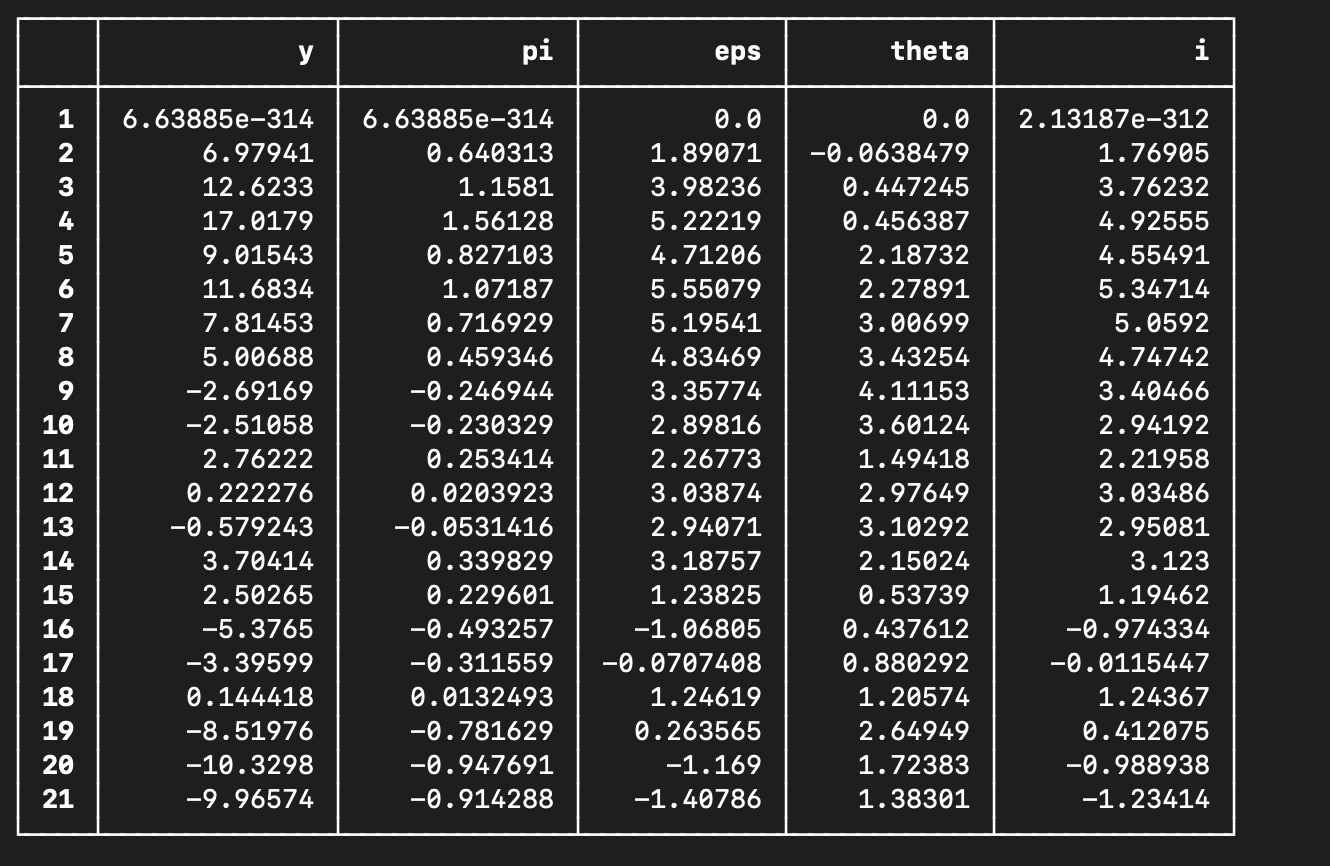

### Итого

Понятно, что изза реализаций с.в. ряды одинаковые не будут, но тут порядок по y на 10 отличается. 
Пока что с этим борюсь. Вероятно, в формулке где-то ошибка. Полагаю, что где-то в H_0. 